In [1]:
import numpy as np
import shap
import pandas as pd
import datetime as dt
from typing import Dict, List

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from lightfm.data import Dataset
from lightfm import LightFM

from catboost import CatBoostClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

In [3]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "my_users_df.csv")
items_df = pd.read_csv(data_folder + "my_items_df.csv")
# train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
train_part = pd.read_csv(data_folder + 'my_train.csv')
local_test = pd.read_csv(data_folder + "test_data.csv")
test_part = local_test.groupby("user_id").agg({"ground_truth": list}).reset_index()
# local_test = pd.read_csv(data_folder + "test_data.csv").rename(columns={'ground_truth': 'item_id'})

In [4]:
train_part['last_watch_dt'] = pd.to_datetime(train_part['last_watch_dt'])

In [5]:
# init class
dataset = Dataset()

# fit tuple of user and movie interactions
dataset.fit(train_part['user_id'].unique(), train_part['item_id'].unique())

In [6]:
train_part['user_id'].nunique(), train_part['item_id'].nunique()

(459099, 12067)

In [7]:
# now, we define lightfm mapper to use it later for checks
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('user mapper length - ', len(lightfm_mapping['users_mapping']))
print('user features mapper length - ', len(lightfm_mapping['user_features_mapping']))
print('movies mapper length - ', len(lightfm_mapping['items_mapping']))
print('Users movie features mapper length - ', len(lightfm_mapping['item_features_mapping']))

user mapper length -  459099
user features mapper length -  459099
movies mapper length -  12067
Users movie features mapper length -  12067


In [8]:
# inverted mappers to check recommendations
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [9]:
# crate mapper for movie_id and title names
item_name_mapper = dict(zip(items_df['item_id'], items_df['title']))

In [10]:
# special iterator to use with lightfm
def df_to_tuple_iterator(df: pd.DataFrame):
    '''
    :df: pd.DataFrame, interactions dataframe
    returs iterator
    '''
    return zip(*df.values.T)

In [11]:
# defining train set on the whole interactions dataset (as HW you will have to split into test and train for evaluation)
train_mat, train_mat_weights = dataset.build_interactions(df_to_tuple_iterator(train_part[['user_id', 'item_id']]))
train_mat, train_mat_weights

(<459099x12067 sparse matrix of type '<class 'numpy.int32'>'
 	with 1224560 stored elements in COOrdinate format>,
 <459099x12067 sparse matrix of type '<class 'numpy.float32'>'
 	with 1224560 stored elements in COOrdinate format>)

In [12]:
# set params
NO_COMPONENTS = 64
LEARNING_RATE = .03
LOSS = 'warp'
MAX_SAMPLED = 5
RANDOM_STATE = 42
EPOCHS = 20

In [13]:
# init model
lfm_model = LightFM(
    no_components = NO_COMPONENTS,
    learning_rate = LEARNING_RATE,
    loss = LOSS,
    max_sampled = MAX_SAMPLED,
    random_state = RANDOM_STATE
    )

In [14]:
# execute training
for _ in tqdm(range(EPOCHS), total = EPOCHS):
    lfm_model.fit_partial(
        train_mat,
        num_threads = 4
    )

100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


In [15]:
top_N = 10
user_id = train_part['user_id'][100]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Rekko for user {user_id}, row number in matrix - {row_id}')

Rekko for user 1003443, row number in matrix - 100


In [16]:
# item indices
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

# predictions
pred = lfm_model.predict(
    row_id,
    all_cols,
    num_threads = 4)
pred, pred.shape

# sort and final postprocessing
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([ 613,  769,  364,  602, 1762,  384,   35,   39,   26, 1354])

In [17]:
# pandas dataframe for convenience
recs = pd.DataFrame({'col_id': top_cols})
recs['item_id'] = recs['col_id'].map(lightfm_mapping['items_inv_mapping'].get)
recs['title'] = recs['item_id'].map(item_name_mapper)
recs

,col_id,item_id,title
0,613,13955,душа
1,769,9342,дэдпул
2,364,13018,король лев (2019)
3,602,4718,вверх
4,1762,6774,тачки 2
5,384,10942,мстители
6,35,15297,клиника счастья
7,39,7626,мстители: война бесконечности
8,26,10440,хрустальный
9,1354,15078,щенячий патруль


In [18]:
# make predictions for all users in test
local_test_preds = pd.DataFrame({
    'user_id': test_part['user_id'].unique()
})
len(local_test_preds)

18693

In [19]:
def generate_lightfm_recs_mapper(
        model: object,
        item_ids: list,
        known_items: dict,
        user_features: list,
        item_features: list,
        N: int,
        user_mapping: dict,
        item_inv_mapping: dict,
        num_threads: int = 4
        ):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(
            user_id,
            item_ids,
            user_features = user_features,
            item_features = item_features,
            num_threads = num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [20]:
# init mapper to get predictions
mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = dict(),
    N = top_N,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 20
)

In [21]:
# get predictions
local_test_preds['item_id'] = local_test_preds['user_id'].map(mapper)
test_part['light'] = local_test_preds['item_id']

In [22]:
evaluate_recommender(df=test_part, model_preds_col="light")

{'ndcg': 0.1728681693805432, 'recall': 0.07507027236582302}

In [23]:
local_test_preds = local_test_preds.explode('item_id')
local_test_preds['rank'] = local_test_preds.groupby('user_id').cumcount() + 1 
local_test_preds['item_name'] = local_test_preds['item_id'].map(item_name_mapper)
print(f'Data shape{local_test_preds.shape}')
local_test_preds.head()

Data shape(186930, 4)


,user_id,item_id,rank,item_name
0,30,13865,1,девятаев
0,30,10440,2,хрустальный
0,30,15297,3,клиника счастья
0,30,9728,4,гнев человеческий
0,30,9103,5,охота


# Catboost

In [24]:
positive_preds = pd.merge(local_test_preds, train_part, how = 'inner', on = ['user_id', 'item_id'])
positive_preds['target'] = 1
positive_preds.shape

(27703, 8)

In [25]:
negative_preds = pd.merge(local_test_preds, train_part, how = 'left', on = ['user_id', 'item_id'])
negative_preds = negative_preds.loc[(negative_preds['watched_pct'].isnull())].sample(frac = .2)
negative_preds['target'] = 0
negative_preds.shape

(31846, 8)

In [26]:
train_users, test_users = train_test_split(
    local_test['user_id'].unique(),
    test_size = 0.2,
    random_state = 13
    )

In [27]:
cbm_train_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(train_users)],
    negative_preds.loc[negative_preds['user_id'].isin(train_users)]]
    )
)

In [28]:
cbm_test_set = shuffle(
    pd.concat(
    [positive_preds.loc[positive_preds['user_id'].isin(test_users)],
    negative_preds.loc[negative_preds['user_id'].isin(test_users)]]
    )
)

In [29]:
cbm_train_set

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target
55394,326785,4151,5,секреты семейной жизни,NaT,NaN,NaN,0
20179,798594,8986,4,тело,2021-07-21,7921.0,100.0,1
76709,453745,4880,10,афера,NaT,NaN,NaN,0
15444,618098,4151,5,секреты семейной жизни,2021-06-28,6717.0,38.0,1
125392,737837,13865,3,девятаев,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...
1239,47283,1650,9,сталинград. мы еще живы или нет?,2021-07-25,129.0,4.0,1
181901,1066377,13865,2,девятаев,NaT,NaN,NaN,0
15250,88538,10440,1,хрустальный,NaT,NaN,NaN,0
88168,521304,1916,9,секс и ничего лишнего,NaT,NaN,NaN,0


In [30]:
USER_FEATURES = ['age', 'income', 'sex', 'kids_flg', 'age_sex', 'income_sex', 'age_income', 
                 'nwatched', 'mean_watched_pct']
ITEM_FEATURES = ['content_type', 'release_year', 'for_kids', 'age_rating', 'countries', 'studios',
                 'decade', 'nwatched', 'mean_watched_pct','mans_percent', 'last_watch', 'month_watched']


In [31]:
cbm_train_set = pd.merge(cbm_train_set, users_df[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])
cbm_test_set = pd.merge(cbm_test_set, users_df[['user_id'] + USER_FEATURES],
                        how = 'left', on = ['user_id'])

In [32]:
# joins item features
gc.collect()
cbm_train_set = pd.merge(cbm_train_set, items_df[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
gc.collect()
cbm_test_set = pd.merge(cbm_test_set, items_df[['item_id'] + ITEM_FEATURES],
                        how = 'left', on = ['item_id'])
gc.collect()

print(cbm_train_set.shape, cbm_test_set.shape)

(47544, 29) (12005, 29)


In [33]:
cbm_train_set.head()

,user_id,item_id,rank,item_name,last_watch_dt,total_dur,watched_pct,target,age,income,...,for_kids,age_rating,countries,studios,decade,nwatched_y,mean_watched_pct_y,mans_percent,last_watch,month_watched
0,326785,4151,5,секреты семейной жизни,NaT,NaN,NaN,0,age_25_34,income_60_90,...,0.0,18.0,россия,studios_unknown,2,21921,4304,43,104,5795
1,798594,8986,4,тело,2021-07-21,7921.0,100.0,1,age_35_44,income_20_40,...,0.0,16.0,испания,studios_unknown,1,1134,5206,44,113,1120
2,453745,4880,10,афера,NaT,NaN,NaN,0,age_35_44,income_20_40,...,0.0,18.0,россия,studios_unknown,2,14280,1151,56,104,4156
3,618098,4151,5,секреты семейной жизни,2021-06-28,6717.0,38.0,1,age_25_34,income_20_40,...,0.0,18.0,россия,studios_unknown,2,21921,4304,43,104,5795
4,737837,13865,3,девятаев,NaT,NaN,NaN,0,NaN,NaN,...,1.0,12.0,россия,studios_unknown,2,29403,6945,60,57,11257


In [34]:
ID_COLS = ['user_id', 'item_id']
TARGET = ['target']
CATEGORICAL_COLS = ['age', 'income', 'sex', 'content_type', 'countries', 'studios',
                    'age_sex', 'income_sex', 'age_income']
DROP_COLS = ['item_name', 'last_watch_dt', 'watched_pct', 'total_dur']

In [35]:
X_train, y_train = cbm_train_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_train_set[TARGET]
X_test, y_test = cbm_test_set.drop(ID_COLS + DROP_COLS + TARGET, axis = 1), cbm_test_set[TARGET]
print(X_train.shape, X_test.shape)

(47544, 22) (12005, 22)


In [36]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_test = X_test.fillna(X_test.mode().iloc[0])

In [37]:
cbm_classifier = CatBoostClassifier(
    loss_function = 'CrossEntropy',
    iterations = 5000,
    learning_rate = 0.007,
    use_best_model=True,
    depth = 8,
    random_state = 42,
    verbose = True
)

In [38]:
cbm_classifier.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds = 100, # to avoid overfitting,
    cat_features = CATEGORICAL_COLS,
    verbose = False
)

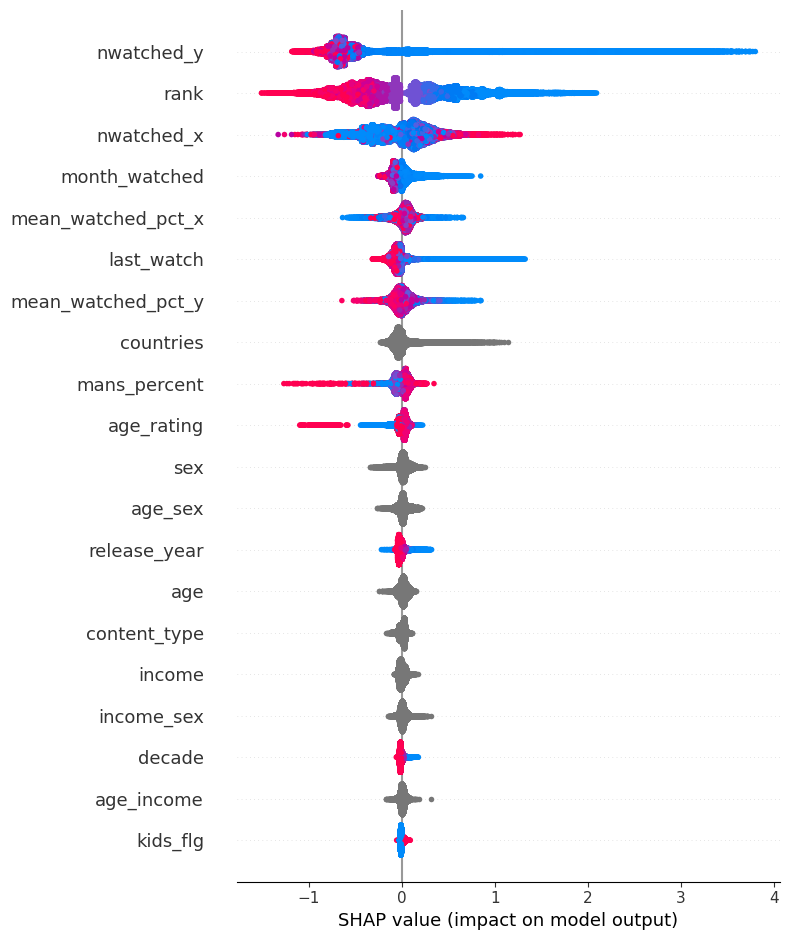

In [39]:
explainer = shap.TreeExplainer(cbm_classifier)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show = False, color_bar = False)

In [40]:
# predictions on test
y_test_pred = cbm_classifier.predict_proba(X_test)

print(f"ROC AUC score = {roc_auc_score(y_test, y_test_pred[:, 1]):.2f}")

ROC AUC score = 0.79


In [41]:
global_test_predictions = pd.DataFrame({
    'user_id': test_part['user_id'].unique()
        }
    )

# filter out cold start users
global_test_predictions = global_test_predictions.loc[global_test_predictions['user_id'].isin(
    train_part.user_id.unique())]

In [42]:
# set param for number of candidates
top_k = 100

# generate list of watched titles to filter
watched_movies = train_part.groupby('user_id')['item_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids = all_cols, 
    known_items = watched_movies,
    N = top_k,
    user_features = None, 
    item_features = None, 
    user_mapping = lightfm_mapping['users_mapping'],
    item_inv_mapping = lightfm_mapping['items_inv_mapping'],
    num_threads = 10
)

global_test_predictions['item_id'] = global_test_predictions['user_id'].map(mapper)
global_test_predictions = global_test_predictions.explode('item_id').reset_index(drop=True)
global_test_predictions['rank'] = global_test_predictions.groupby('user_id').cumcount() + 1 

In [43]:
cbm_global_test = pd.merge(global_test_predictions, users_df[['user_id'] + USER_FEATURES],
                         how = 'left', on = ['user_id'])

cbm_global_test = pd.merge(cbm_global_test, items_df[['item_id'] + ITEM_FEATURES],
                         how = 'left', on = ['item_id'])
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,age_sex,income_sex,age_income,...,for_kids,age_rating,countries,studios,decade,nwatched_y,mean_watched_pct_y,mans_percent,last_watch,month_watched
0,30,13865,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,12.0,россия,studios_unknown,2,29403,6945,60,57,11257
1,30,10440,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,18.0,россия,studios_unknown,2,46131,4827,45,104,15428
2,30,15297,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,18.0,россия,studios_unknown,2,44703,5639,32,74,25443
3,30,9728,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,18.0,"великобритания, сша",studios_unknown,2,27188,6211,57,59,15390
4,30,9103,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,18.0,сша,studios_unknown,2,856,5103,56,125,854


In [44]:
cbm_global_test = cbm_global_test.fillna(cbm_global_test.mode().iloc[0])
cbm_global_test['cbm_preds'] = cbm_classifier.predict_proba(cbm_global_test[X_train.columns])[:, 1]
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,age_sex,income_sex,age_income,...,age_rating,countries,studios,decade,nwatched_y,mean_watched_pct_y,mans_percent,last_watch,month_watched,cbm_preds
0,30,13865,1,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,12.0,россия,studios_unknown,2,29403,6945,60,57,11257,0.427648
1,30,10440,2,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,россия,studios_unknown,2,46131,4827,45,104,15428,0.394517
2,30,15297,3,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,россия,studios_unknown,2,44703,5639,32,74,25443,0.333560
3,30,9728,4,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,"великобритания, сша",studios_unknown,2,27188,6211,57,59,15390,0.336724
4,30,9103,5,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,сша,studios_unknown,2,856,5103,56,125,854,0.790750


In [45]:
cbm_global_test['cbm_preds'] = cbm_classifier.predict_proba(cbm_global_test[X_train.columns])[:, 1]
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,age_sex,income_sex,age_income,...,age_rating,countries,studios,decade,nwatched_y,mean_watched_pct_y,mans_percent,last_watch,month_watched,cbm_preds
0,30,13865,1,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,12.0,россия,studios_unknown,2,29403,6945,60,57,11257,0.427648
1,30,10440,2,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,россия,studios_unknown,2,46131,4827,45,104,15428,0.394517
2,30,15297,3,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,россия,studios_unknown,2,44703,5639,32,74,25443,0.333560
3,30,9728,4,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,"великобритания, сша",studios_unknown,2,27188,6211,57,59,15390,0.336724
4,30,9103,5,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,18.0,сша,studios_unknown,2,856,5103,56,125,854,0.790750


In [46]:
# define cbm rank
cbm_global_test = cbm_global_test.sort_values(by = ['user_id', 'cbm_preds'], ascending = [True, False])
cbm_global_test['cbm_rank'] = cbm_global_test.groupby('user_id').cumcount() + 1
cbm_global_test.head()

,user_id,item_id,rank,age,income,sex,kids_flg,age_sex,income_sex,age_income,...,countries,studios,decade,nwatched_y,mean_watched_pct_y,mans_percent,last_watch,month_watched,cbm_preds,cbm_rank
84,30,14717,85,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,великобритания,studios_unknown,-1,399,1920,54,17,399,0.967571,1
23,30,2743,24,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,"великобритания, сша",studios_unknown,1,132,5099,42,44,25,0.961690,2
96,30,273,97,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,сша,studios_unknown,1,288,4327,55,46,210,0.947911,3
59,30,15648,60,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,"франция, италия, тунис",studios_unknown,1,454,5174,59,29,454,0.933627,4
64,30,16406,65,age_25_34,income_20_40,М,False,age_25_34_Ж,income_20_40_Ж,age_25_34_income_20_40,...,сша,studios_unknown,1,925,1493,50,30,925,0.914609,5


In [47]:
test_part['Cat_boost'] = cbm_global_test.groupby("user_id").agg({"item_id": list}).reset_index().item_id

In [48]:
test_part

,user_id,ground_truth,light,Cat_boost
0,30,"[8584, 3031, 15363]","[13865, 10440, 15297, 9728, 9103, 10464, 3734,...","[14717, 2743, 273, 15648, 16406, 7597, 5325, 7..."
1,144,"[3800, 11987, 10942]","[741, 16166, 15297, 10440, 3182, 7571, 13865, ...","[896, 8134, 9465, 5906, 15568, 3696, 3349, 970..."
2,241,"[14841, 6162, 5808, 15266]","[11985, 3182, 4718, 11919, 10761, 7571, 13018,...","[1659, 9681, 13254, 1115, 13453, 11689, 13373,..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]","[15297, 10440, 9728, 13865, 4151, 6809, 4495, ...","[15793, 15942, 16406, 12615, 6447, 2865, 4209,..."
4,475,"[6214, 3734, 6686]","[15297, 14899, 10440, 9728, 4718, 3734, 4151, ...","[14899, 4266, 14883, 13087, 4239, 10593, 9336,..."
...,...,...,...,...
18688,1097316,"[11640, 15297, 4151]","[10440, 15297, 13865, 9728, 4151, 3734, 4880, ...","[2720, 3784, 11863, 12396, 1465, 7476, 14526, ..."
18689,1097429,"[6964, 16166, 11911, 13927, 710, 3392, 14725, ...","[3182, 16166, 15266, 11985, 13935, 7571, 8254,...","[12449, 10015, 2356, 11868, 2787, 2625, 9702, ..."
18690,1097444,"[13586, 10489, 13650, 12841, 11991, 13099, 127...","[7626, 12841, 14317, 6825, 682, 12173, 1785, 8...","[13883, 2590, 8419, 8972, 3166, 1915, 5937, 84..."
18691,1097459,"[5507, 11844, 7793]","[13865, 10440, 12995, 4880, 9728, 13018, 3734,...","[4762, 4040, 9222, 957, 12516, 16080, 15034, 5..."


In [49]:
evaluate_recommender(test_part, model_preds_col="Cat_boost")

{'ndcg': 0.4784960218437449, 'recall': 0.2646904737023886}